In [34]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import datetime as dt
import matplotlib.pyplot as plt
import folium

In [43]:
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'

In [7]:
data_path = "./data"
files = os.listdir(data_path)
len(files)

1

In [8]:
fname = files[0]

In [9]:
data = pd.read_pickle(os.path.join(data_path,files[0]))
time = dt.datetime.strptime(fname.split(".")[0], "%Y-%m-%d %H-%M-%S")+dt.timedelta(hours=5)

In [10]:
rws = data['RWS'][0]['RW']
fis = [x['FIS'][0]['FI'] for x in rws]

In [11]:
fisis = [direction for subfis in fis for direction in subfis]

In [12]:
#Jam Factor
JFS = [x['CF'][0]['JF'] for x in fisis]

In [13]:
IDS = [str(x['TMC']['PC'])+x['TMC']['QD'] for x in fisis]

In [14]:
LIS = [x['LI'] for x in rws]
SHPS = [x['SHP'] for x in fisis]
FCS = [np.mean([x['FC'] for x in y]) for y in SHPS]
SHPS_string=["".join(list(np.array([x['value'] for x in shp]).flatten())) for shp in SHPS]

In [15]:
df = pd.DataFrame({'JF':JFS,'FC':FCS,'ID':IDS,'shape':SHPS_string})

In [16]:
df.head()

,JF,FC,ID,shape
0,0.00000,3.0,383+,"-6.14397,106.88627 -6.1443,106.88617"
1,2.18403,3.0,382+,"-6.14915,106.88461 -6.14923,106.88459 -6.14931..."
2,0.33059,3.0,382-,"-6.14956,106.88459 -6.14941,106.88458 -6.14941..."
3,0.00000,3.0,383-,"-6.1443,106.88617 -6.14397,106.88627 -6.14915,..."
4,0.00000,4.0,385-,"-6.17761,106.62998 -6.17767,106.63034"


In [17]:
len(df)

16975

In [18]:
gdf = df[['ID','shape','FC']].copy()
gdf['geometry'] = gdf['shape'].apply(lambda s: LineString(map(lambda x: Point(eval(x)[::-1]),s.strip().split(" "))))
gdf=gpd.GeoDataFrame(gdf)
gdf.crs = {'init':'epsg:4326'}
gdf.head()

,ID,shape,FC,geometry
0,383+,"-6.14397,106.88627 -6.1443,106.88617",3.0,"LINESTRING (106.88627 -6.14397, 106.88617 -6.1..."
1,382+,"-6.14915,106.88461 -6.14923,106.88459 -6.14931...",3.0,"LINESTRING (106.88461 -6.14915, 106.88459 -6.1..."
2,382-,"-6.14956,106.88459 -6.14941,106.88458 -6.14941...",3.0,"LINESTRING (106.88459 -6.14956, 106.88458 -6.1..."
3,383-,"-6.1443,106.88617 -6.14397,106.88627 -6.14915,...",3.0,"LINESTRING (106.88617 -6.1443, 106.88627 -6.14..."
4,385-,"-6.17761,106.62998 -6.17767,106.63034",4.0,"LINESTRING (106.62998 -6.17761, 106.63034 -6.1..."


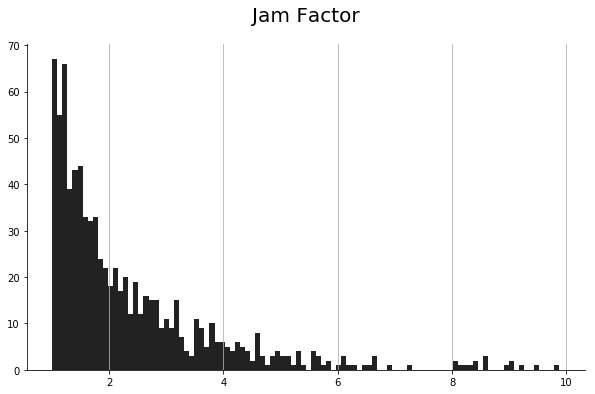

In [19]:
# now let's take a look at the jam factor
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
df[df.JF>1].JF.hist(bins=100, color="#222222",ax=ax)
ax.set_title("Jam Factor", fontsize=20, y=1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis="y")


In [20]:
df['group']=pd.cut(df.JF,[-1,1,3,4,8,11]).cat.codes

In [21]:
gdf.shape

(16975, 4)

In [24]:
gdf_clean.shape

NameError: name 'gdf_clean' is not defined

In [36]:
# my geo
u,l=-6.049427, 106.525587
b,r=-6.511087, 107.183457
x = [l,r,r,l]
y = [b,b,u,u]
bound=Polygon([[px, py] for px,py in zip(x,y)])
bd=gpd.GeoDataFrame(pd.Series([bound]).reset_index().rename(columns={0:'geometry'}))
bd.crs={'init':'epsg:4326'}

In [37]:
gdf_ok = gpd.sjoin(gdf,bd)

In [38]:
gdf_w_data = pd.merge(gdf_ok,df[['ID','JF','group']],on="ID")

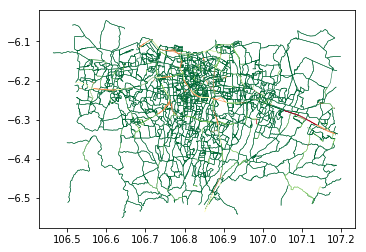

In [57]:
gdf_w_data.sort_values("JF").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)

In [47]:
def plot_folium(tes, fname, save=True):
    m=folium.Map((-6.223996, 106.828303), zoom_start=12,
                tiles="https://cartodb-basemaps-{s}.global.ssl.fastly.net/dark_nolabels/{z}/{x}/{y}.png",
                #tiles = "https://{s}.basemaps.cartocdn.com/base-dark/{z}/{x}/{y}.png",
                 attr=attr)
    color={2:'#069E2D',0:'#034732',1:'#008148',3:'#F5BB00',4:'#FB5012'}
    style_function = lambda x: {
        'color' : color[x['properties']['group']],
        'weight' : 5/x['properties']['FC']
    }
    tes_=tes
    for wi in np.sort(tes['FC'].unique())[::-1]:
            for c in np.sort(tes['group'].unique()):
                the_df=tes_[(tes_['FC']==wi)&(tes_['group']==c)]
                if len(the_df)==0:
                    continue
                else:
                    folium.GeoJson(the_df, style_function=style_function).add_to(m)
    if save==True:
        m.save(fname)
    else:
        return m

In [65]:
plot_folium(gdf_w_data, "test.html", save=True)